# Backtest a Single Model 

The way to gauge the performance of a time-series model is through re-training models with different historic periods and check their forecast within certain steps. This is similar to a time-based style cross-validation. More often, we called it `backtest` in time-series modeling.

The purpose of this notebook is to illustrate how to do 'backtest' on a single model using `BackTester`

`BackTester` will compose a `TimeSeriesSplitter` within it, but `TimeSeriesSplitter` is useful as a standalone, in case there are other tasks to perform that requires splitting but not backtesting. You can also retrieve the composed `TimeSeriesSplitter` object from `BackTester` to utilize the additional methods in `TimeSeriesSplitter`

Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.plot import plot_bt_predictions
from orbit.diagnostics.metrics import smape, wmape
from orbit.utils.dataset import load_iclaims
from orbit.utils.plot import get_orbit_style

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load data

In [3]:
raw_data = load_iclaims()
data = raw_data.copy()

print(data.shape)

data.head(5)

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## Create a BackTester

In [4]:
# instantiate a model

dlt = DLT(date_col='week',
             response_col='claims',
             regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
             seasonality=52,
         estimator='stan-map')

In [5]:
bt = BackTester(model=dlt,
                df=data,
                min_train_len=100,
                incremental_len=100,
                forecast_len=20)

## Backtest Fit and Predict

The most expensive portion of backtesting is fitting the model iteratively. Thus, we separate the API calls for `fit_predict` and `score` to avoid redundant computation for multiple metrics or scoring methods.

In [6]:
bt.fit_predict();

Once `fit_predict()` is called, the fitted models and predictions can be easily retrieved from `BackTester`. Here the data is grouped by the date, split_key, and whether or not that observation is part of the training or test data.

In [7]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,split_key,training_data,actual,prediction
0,2010-01-03,0,True,13.386595,13.386595
1,2010-01-10,0,True,13.624218,13.640867
2,2010-01-17,0,True,13.398741,13.375500
3,2010-01-24,0,True,13.137549,13.152080
4,2010-01-31,0,True,13.196760,13.196777


We also provide a plotting utility to visualize the predictions against the actuals for each split.

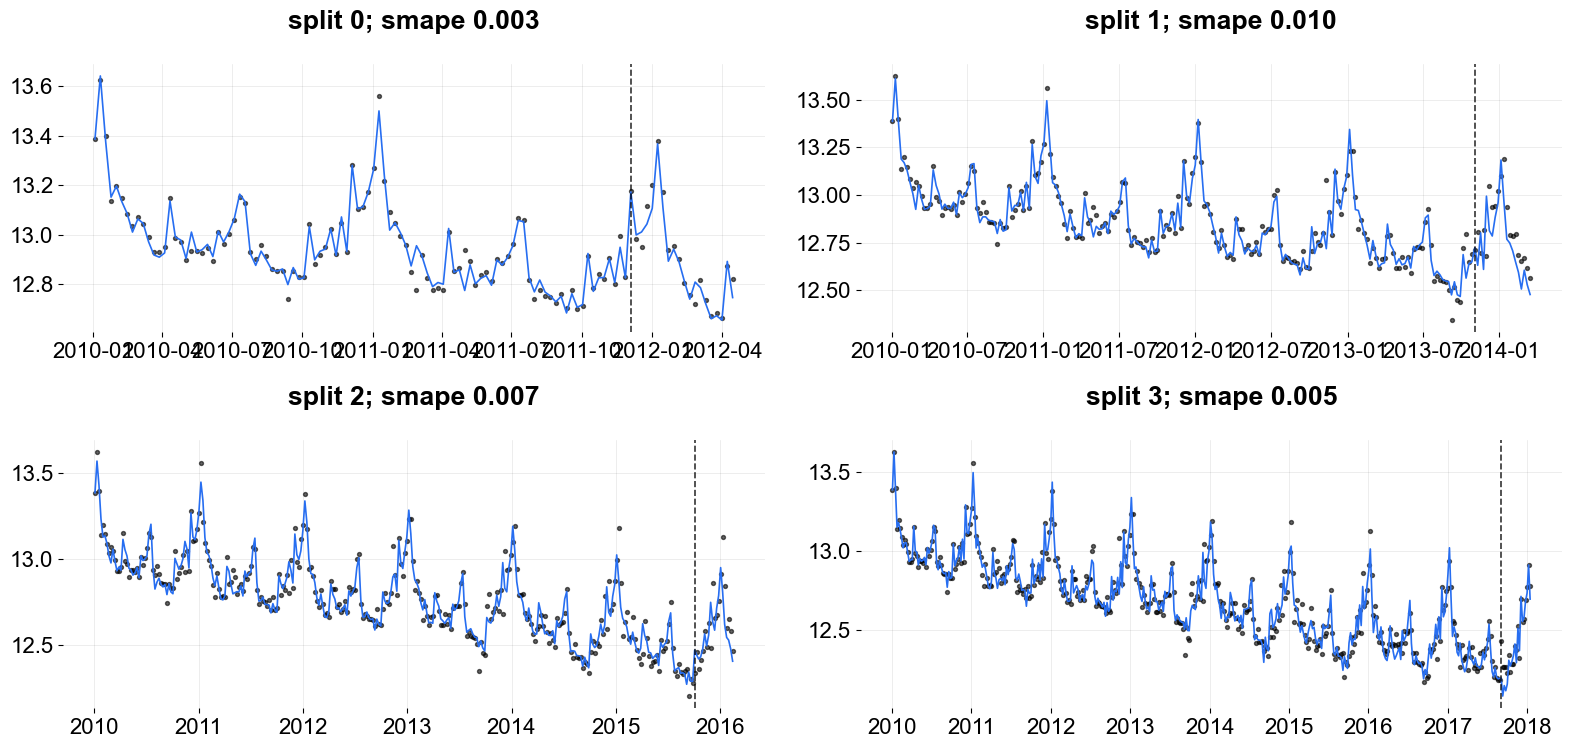

In [8]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True);

Users might find this useful for any custom computations that may need to be performed on the set of predicted data. Note that the columns are renamed to generic and consistent names.

Sometimes, it might be useful to match the data back to the original dataset for ad-hoc diagnostics. This can easily be done by merging back to the orignal dataset

In [9]:
predicted_df.merge(data, left_on='date', right_on='week')

,date,split_key,training_data,actual,prediction,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,0,True,13.386595,13.386595,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-03,1,True,13.386595,13.386595,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
2,2010-01-03,2,True,13.386595,13.386595,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
3,2010-01-03,3,True,13.386595,13.386595,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
4,2010-01-10,0,True,13.624218,13.640867,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2017-12-17,3,False,12.568616,12.578723,2017-12-17,12.568616,0.298663,0.248654,-0.216869,0.434042,-0.482380
1076,2017-12-24,3,False,12.691451,12.682765,2017-12-24,12.691451,0.328516,0.233616,-0.358839,0.430410,-0.373389
1077,2017-12-31,3,False,12.769532,12.732821,2017-12-31,12.769532,0.503457,0.069313,-0.092571,0.456087,-0.553539
1078,2018-01-07,3,False,12.908227,12.910995,2018-01-07,12.908227,0.527849,0.051295,0.029532,0.471673,-0.456456


## Backtest Scoring

The main purpose of `BackTester` are the evaluation metrics. Some of the most widely used metrics are implemented and built into the `BackTester` API.

The default metric list is **smape, wmape, mape, mse, mae, rmsse**.

In [10]:
bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.006225,False
1,wmape,0.006215,False
2,mape,0.006206,False
3,mse,0.012128,False
4,mae,0.078946,False
5,rmsse,0.786049,False


It is possible to filter for only specific metrics of interest, or even implement your own callable and pass into the `score()` method. For example, see this function that uses last observed value as a predictor and computes the `mse`. Or `naive_error` which computes the error as the delta between predicted values and the training period mean. 

Note these are not really useful error metrics, just showing some examples of callables you can use ;)

In [11]:
def mse_naive(test_actual):
    actual = test_actual[1:]
    predicted = test_actual[:-1]
    return np.mean(np.square(actual - predicted))


def naive_error(train_actual, test_predicted):
    train_mean = np.mean(train_actual)
    return np.mean(np.abs(test_predicted - train_mean))

In [12]:
bt.score(metrics=[mse_naive, naive_error])

,metric_name,metric_values,is_training_metric
0,mse_naive,0.019628,False
1,naive_error,0.227063,False


It doesn't take additional time to refit and predict the model, since the results are stored when `fit_predict()` is called. Check docstrings for function criteria that is required for it to be supported with this API.

In some cases, we may want to evaluate our metrics on both train and test data. To do this you can call score again with the following indicator

In [13]:
bt.score(include_training_metrics=True)

,metric_name,metric_values,is_training_metric
0,smape,0.006225,False
1,wmape,0.006215,False
2,mape,0.006206,False
3,mse,0.012128,False
4,mae,0.078946,False
5,rmsse,0.786049,False
6,smape,0.002688,True
7,wmape,0.002684,True
8,mape,0.002687,True
9,mse,0.002978,True


## Backtest Get Models

In cases where `BackTester` doesn't cut it or for more custom use-cases, there's an interface to export the `TimeSeriesSplitter` and predicted data, as shown earlier. It's also possible to get each of the fitted models for deeper diving.

In [14]:
fitted_models = bt.get_fitted_models()

In [15]:
model_1 = fitted_models[0]

model_1.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,-0.049384
1,trend.filling,Regular,-0.034050
2,trend.job,Regular,0.274457


### Get TimeSeriesSplitter

BackTester composes a TimeSeriesSplitter within it, but TimeSeriesSplitter can also be created on its own as a standalone object. See section below on TimeSeriesSplitter for more details on how to use the splitter.

All of the additional TimeSeriesSplitter args can also be passed into BackTester on instantiation

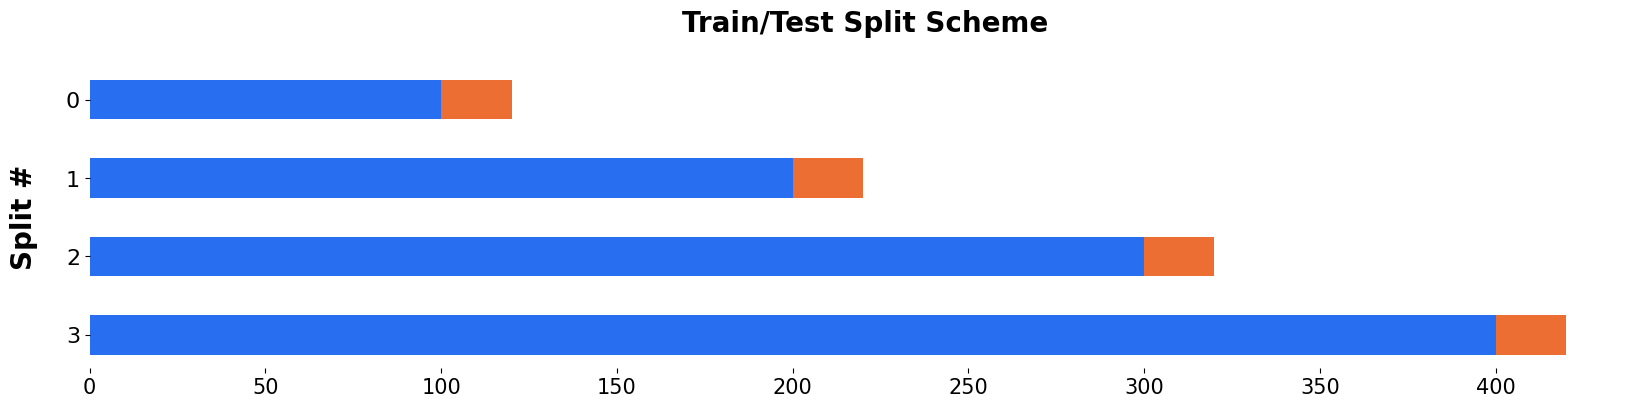

In [16]:
ts_splitter = bt.get_splitter()
ts_splitter.plot()
plt.grid();

## Appendix

### Create a TimeSeriesSplitter

####  Expanding window

In [17]:
min_train_len = 380
forecast_len = 20
incremental_len = 20

In [18]:
ex_splitter = TimeSeriesSplitter(df=data,
                                 min_train_len=min_train_len,
                                 incremental_len=incremental_len,
                                 forecast_len=forecast_len, 
                                 window_type='expanding',
                                 date_col='week')

In [19]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start index: 0 Train end index: 379
Test start index: 380 Test end index: 399
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start index: 0 Train end index: 399
Test start index: 400 Test end index: 419
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start index: 0 Train end index: 419
Test start index: 420 Test end index: 439
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



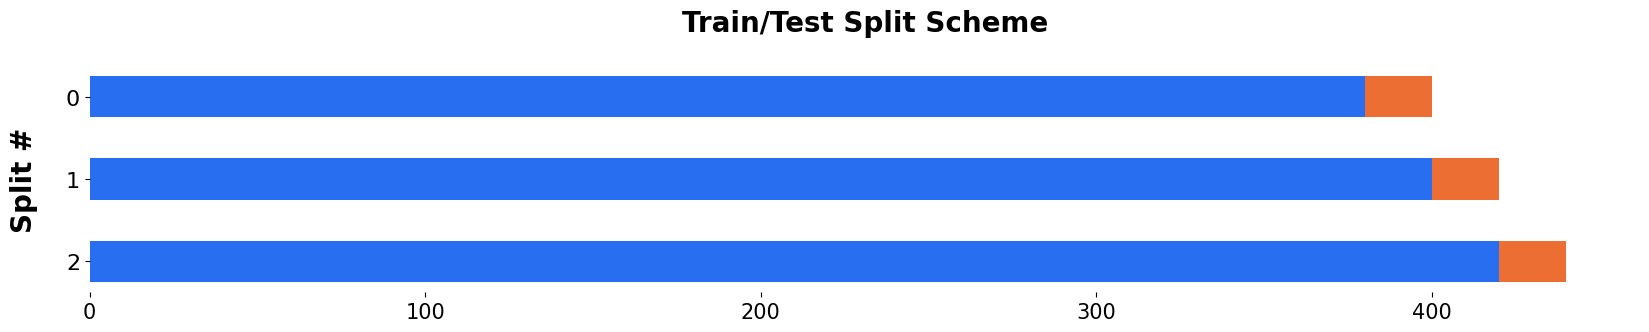

In [20]:
ex_splitter.plot()

plt.grid();

#### Rolling window

In [21]:
roll_splitter = TimeSeriesSplitter(df=data,
                                   min_train_len=min_train_len,
                                   incremental_len=incremental_len,
                                   forecast_len=forecast_len, 
                                   window_type='rolling',
                                   date_col='week')

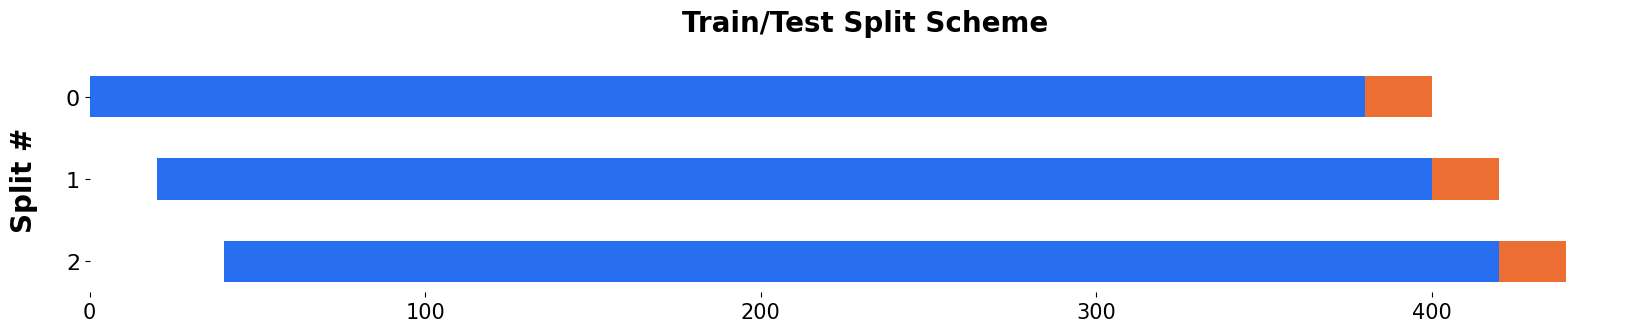

In [22]:
roll_splitter.plot()
plt.grid();

#### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [23]:
ex_splitter2 = TimeSeriesSplitter(df=data,
                                  min_train_len=min_train_len,
                                  incremental_len=incremental_len,
                                  forecast_len=forecast_len, 
                                  n_splits=5,
                                  window_type='expanding',
                                  date_col='week')

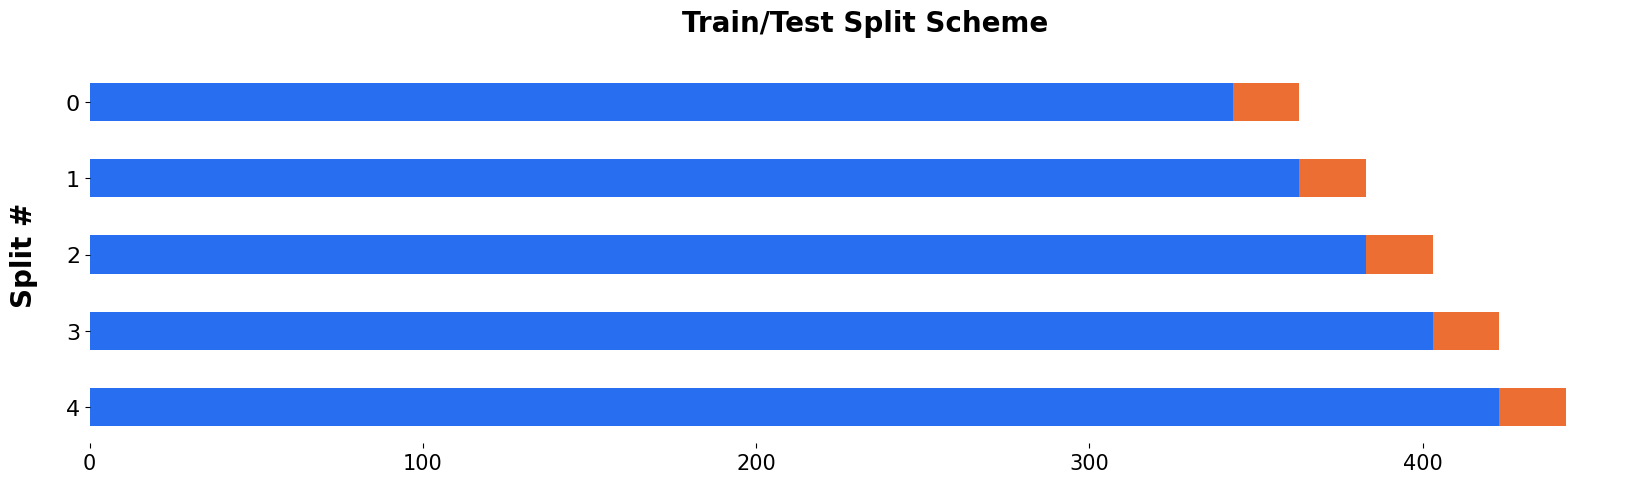

In [24]:
ex_splitter2.plot()

plt.grid();